In [1]:
#meta 10/11/2020 myTry Ch 4&5. Image Classification (multilabel) - MNIST full.

#change log
#prev 10/11/2020 TRAIN MNIST CLASSIFIER, WITH AND WITHOUT PRETRAINED MODEL

#prev 10/12/2020 PICKLE DATA FOR REUSE
#      Save dls_train and dls_test 
#      Load pre-pickled data if available.

#here 10/12/2020 IMPROVE MODELS. LEARNING RATE FINDER. UNDER THE HOOD OF FINE_TUNE(). TO_FP16.
#      Load dls_train and dls_test from pickle
#      Try different combinations to improve model.
#      Use fine_tune() and manually fine_tune.


In [2]:
#load modules
from fastbook import *
from fastai.vision.all import *

Global vars and functions

#### Automated Learning Rate Suggester

In [40]:
#src https://forums.fast.ai/t/automated-learning-rate-suggester/44199/7
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

# Image Classification - MNIST
full dataset

## 0. Load Data

If no pre-pickled data, then get it from source and pickle for future reuse.

In [4]:
#!pwd => /home/jupyter
try:
    dls_train = torch.load('myData/mnist_full_dls_train.pkl') #class fastai.data.core.DataLoaders
    dls_test = torch.load('myData/mnist_full_dls_test.pkl') 
    
    #set flag
    flg_data_pkl = True
except:
    flg_data_pkl = False

In [5]:
if not flg_data_pkl:
    print(URLs.MNIST)
    
    path = untar_data(URLs.MNIST)
    #set path reference
    Path.BASE_PATH = path

    #see what's in our dataset -> 2 directories
    print("Path folders: ", path.ls())

Files organization: train and test folders, then each digit in its own folder.

In [6]:
if not flg_data_pkl:
    #files structure
    print((path/"training").ls()) #class fastcore.foundation.L
    print((path/"training/7").ls())
    

In [7]:
if not flg_data_pkl:
     #look at one image
    fname = (path/"training/7").ls()[0]

try:
    Image.open(fname)
except:
    print("skip")

skip


## 1. Preprocess Data
#### Train set
Get all files from `training` folder and make them available as train and valid.

In [8]:
if not flg_data_pkl:
    digits_train = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct = 0.2, seed=42),
                 get_y = parent_label, 
                 item_tfms=Resize(128))#,
                 #batch_tfms=aug_transforms(size=224, min_scale=0.75)
        
    dls_train = digits_train.dataloaders(path/"training")
    
    print(digits_train.__class__, dls_train.__class__)

#### Test set
Get all files from `testing` folder.  Don't use it for training.  Hold it for measuring model performance.

In [9]:
if not flg_data_pkl:
    digits_test = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 get_y = parent_label, 
                 item_tfms=Resize(128))
    
    dls_test = digits_test.dataloaders(path/"testing")

Pickle files for reuse and saving GCP money

In [10]:
if not flg_data_pkl:
    #torch.save( digits_train, 'myData/mnist_full_datablock_train.pkl') #class fastai.data.block.DataBlock
    #torch.save( digits_test, 'myData/mnist_full_datablock_test.pkl') 
    torch.save( dls_train, 'myData/mnist_full_dls_train.pkl') #class fastai.data.core.DataLoaders
    torch.save( dls_test, 'myData/mnist_full_dls_test.pkl')


#### Checking and Debugging a DataBlock

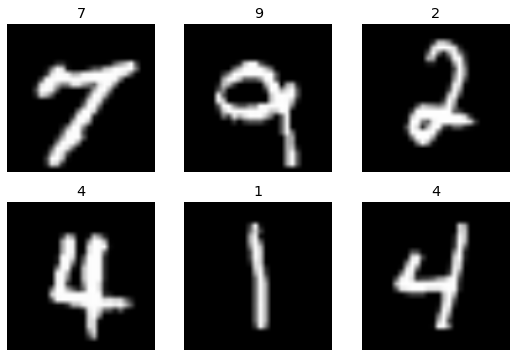

In [11]:
dls_train.show_batch(nrows=2, ncols=3)

## 2. Train model
### 2.1 Using fast.ai cnn learner, without pretrained model

In [12]:
#pg.180
my_learn = cnn_learner(dls_train, resnet34, pretrained=False, metrics=error_rate)
my_learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,error_rate,time
0,0.125146,0.071886,0.016917,03:01


#### 2.1a View activations and labels
on one batch

In [13]:
#get a batch of real data from DataLoaders
x_train,y_train = dls_train.one_batch()

In [14]:
#preview actuals
y_train

TensorCategory([5, 7, 9, 0, 0, 1, 8, 4, 7, 0, 6, 0, 4, 1, 9, 2, 6, 6, 9, 1, 0, 2, 1, 0, 5, 8, 4, 4, 9, 4, 3, 2, 8, 9, 5, 2, 8, 5, 9, 1, 0, 2, 4, 8, 0, 3, 7, 0, 8, 2, 5, 7, 4, 0, 7, 9, 7, 4, 7, 5, 9, 4, 4, 9],
       device='cuda:0')

In [15]:
#preview first prediction
preds,_ = my_learn.get_preds(dl=[(x_train,y_train)])
preds[0]

tensor([4.3886e-09, 2.7305e-11, 4.1087e-09, 1.3123e-07, 1.3724e-11, 1.0000e+00, 2.7756e-09, 4.0228e-08, 4.1873e-08, 2.9755e-06])

In [16]:
#make sure add up to 1
len(preds[0]),preds[0].sum()

(10, tensor(1.0000))

#### 2.1b Check Model Performance
on the validation set

In [17]:
print("Loss function:")
my_learn.loss_func

Loss function:


FlattenedLoss of CrossEntropyLoss()

In [18]:
#learn.metrics[0].__class__ #fastai.learner.AvgMetric
print("Metric: error rate")
my_learn.metrics[0].value

Metric: error rate


TensorCategory(0.0156)

## Model Interpretation

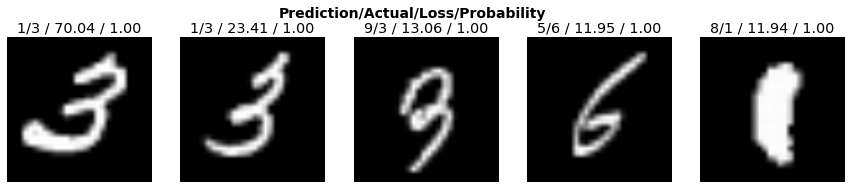

In [19]:
interp = ClassificationInterpretation.from_learner(my_learn)
interp.plot_top_losses(5, nrows=1)

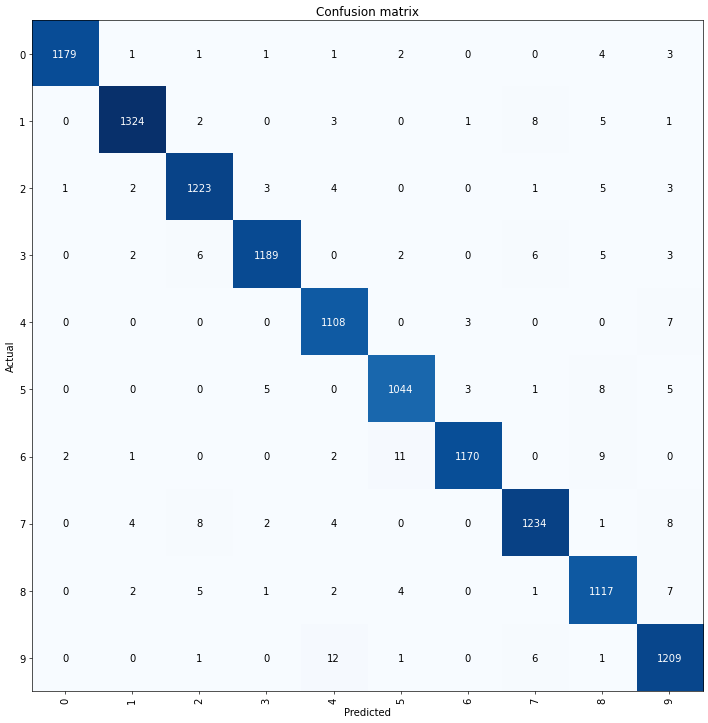

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
interp.most_confused(min_val=6)

[('9', '4', 12),
 ('6', '5', 11),
 ('6', '8', 9),
 ('1', '7', 8),
 ('5', '8', 8),
 ('7', '2', 8),
 ('7', '9', 8),
 ('4', '9', 7),
 ('8', '9', 7),
 ('3', '2', 6),
 ('3', '7', 6),
 ('9', '7', 6)]

### 2.2 Using fast.ai cnn learner, with pretrained model Resnet34

In [22]:
my_learn1 = cnn_learner(dls_train, resnet34, metrics=error_rate)
my_learn1.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.202220,0.125577,0.038583,01:34


epoch,train_loss,valid_loss,error_rate,time
0,0.044552,0.033707,0.009000,02:16
1,0.014531,0.019014,0.005333,02:16


#### 2.2a View activations and labels
on one batch

In [23]:
#preview predictions
my_preds1,_ = my_learn1.get_preds(dl=[(x_train,y_train)])
print(my_preds1[0])

#make sure add up to 1
len(my_preds1[0]),my_preds1[0].sum()

tensor([0.0501, 0.7256, 0.0109, 0.0064, 0.0218, 0.0066, 0.0110, 0.0060, 0.1556, 0.0059])


(10, tensor(1.))

#### 2.2b Check Model Performance
on the validation set

In [24]:
print("Metric: error rate")
my_learn1.metrics[0].value

Metric: error rate


TensorCategory(0.7969)

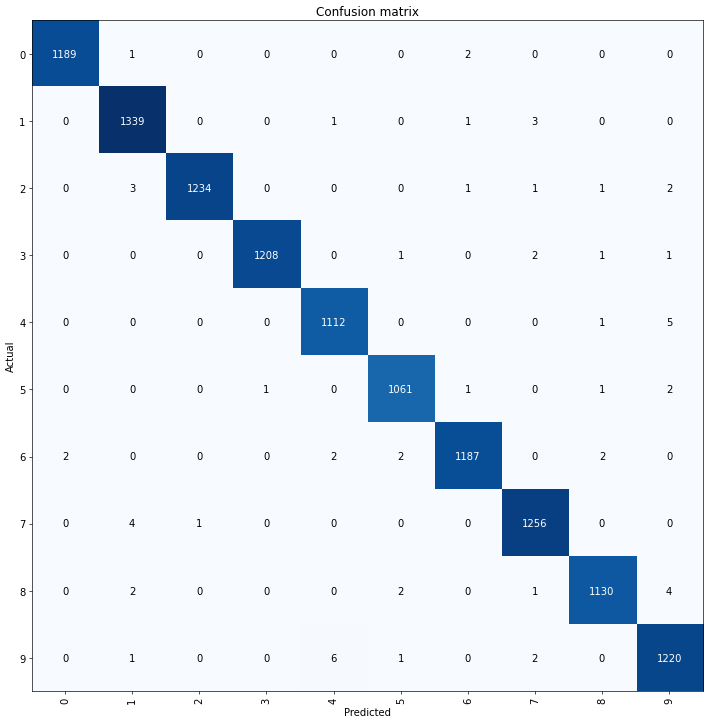

In [25]:
my_interp1 = ClassificationInterpretation.from_learner(my_learn1)
my_interp1.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [26]:
my_interp1.most_confused(min_val=4)

[('9', '4', 6), ('4', '9', 5), ('7', '1', 4), ('8', '9', 4)]

## 3. Improving Our Model
If pick a lr too high, the error rate gets worse - $note: couldn't make it happen

In [27]:
#learn = cnn_learner(dls_train, resnet34, metrics=error_rate)
#learn.fine_tune(1, base_lr=10.0)

#### The Learning Rate Finder
by Leslie Smith

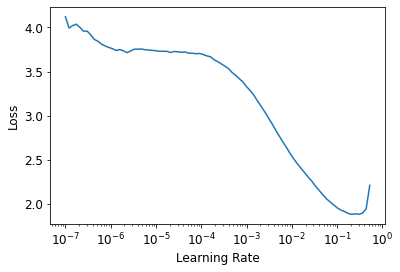

In [35]:
learn = cnn_learner(dls_train, resnet34, metFrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [36]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 2.09e-02, steepest point: 3.63e-03


0.013182567385564075

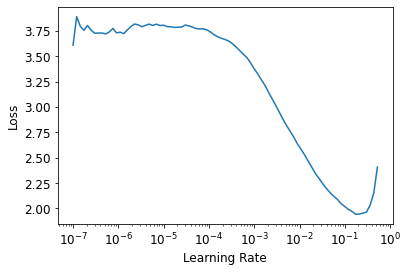

In [42]:
find_appropriate_lr(learn)

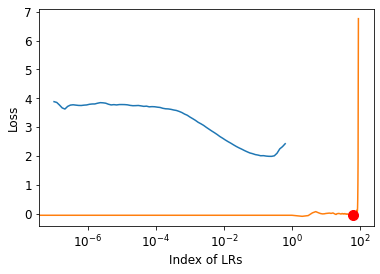

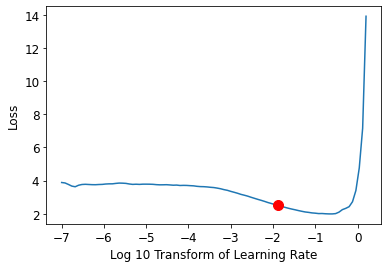

0.013182567385564075

In [43]:
find_appropriate_lr(learn, plot=True)

Picked rate: 1.318e-02

In [46]:
learn = cnn_learner(dls_train, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=1.318e-02)

epoch,train_loss,valid_loss,error_rate,time
0,0.140336,0.098625,0.024667,01:35


epoch,train_loss,valid_loss,error_rate,time
0,0.082809,0.043270,0.010917,02:16
1,0.023017,0.020050,0.004750,02:16


Picked rate: rule of thumb min/10 = 2.09e-02

In [48]:
learn = cnn_learner(dls_train, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=2.09e-02)

epoch,train_loss,valid_loss,error_rate,time
0,0.146729,0.111241,0.022500,01:35


epoch,train_loss,valid_loss,error_rate,time
0,0.083824,0.063266,0.018000,02:16
1,0.021511,0.019332,0.004917,02:16


## Under the hood of learner.fine_tune()

In [49]:
learn.fine_tune??

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
)
Source:   
@patch
@log_args(but_as=Learner.fit)
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `freeze` for `freeze_epochs` then with `unfreeze` from `epochs` using discriminative LR"
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      /opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py
Type:      method


#### Unfreezing and Transfer Learning

do it by hand

In [51]:
#cnn_learner by default freezes the model for us
learn = cnn_learner(dls_train, resnet34, metrics=error_rate)

#3 epochs of training just the last layer
learn.fit_one_cycle(3, 1.318e-02)

#manually unfreeze
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,time
0,0.131860,0.108247,0.026583,01:35
1,0.059618,0.031685,0.008083,01:34
2,0.029609,0.020891,0.005500,01:33


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=7.585775847473997e-07)

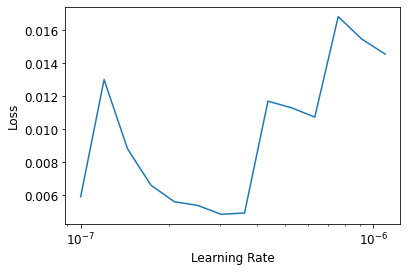

In [52]:
#maybe at this point not the right learning rate, so run `lr_find()` again
#don't see a sharp drop any more (hard to improve), see a gentle little gradient
#not really - a weird plot, not sure how to interpret
learn.lr_find()

In [56]:
#after unfreezing, find a new learning rate and do a bunch more -> should get a lower error rate
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.015528,0.020681,0.005167,02:15
1,0.015188,0.019389,0.005333,02:15
2,0.013879,0.016905,0.004750,02:15
3,0.006123,0.018540,0.004750,02:15
4,0.005252,0.017270,0.004917,02:15
5,0.003395,0.017341,0.004833,02:15


Notice no improvement in error rate after 3rd epoch, and worse error_rate after 5th epoch.

#### Discriminative Learning Rates
Different layers of network want to be trained at different rates  
Provide `lr_max` with a slice of learning rates

In [57]:
#putting it all together
learn = cnn_learner(dls_train, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 1.318e-02)
learn.unfreeze()
learn.fit_one_cycle(6, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.135717,0.152817,0.036750,01:34
1,0.042887,0.033726,0.009083,01:34
2,0.019079,0.022452,0.006000,01:34


epoch,train_loss,valid_loss,error_rate,time
0,0.018781,0.021773,0.006083,02:14
1,0.018927,0.020485,0.005167,02:15
2,0.014608,0.021153,0.005583,02:15
3,0.008224,0.021322,0.004917,02:15
4,0.006950,0.021406,0.004667,02:15
5,0.005576,0.021167,0.004583,02:15


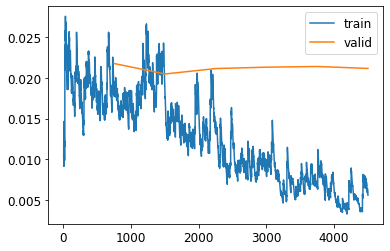

In [58]:
learn.recorder.plot_loss()

### Selecting the Number of Epochs

### Deeper Architectures
`to_fp16` less precision, less memory needed, much faster training

In [59]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls_train, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,0.265310,0.160202,0.049083,01:17
1,0.131369,0.086661,0.024833,01:17
2,0.068093,0.052500,0.013833,01:17


epoch,train_loss,valid_loss,error_rate,time
0,0.058842,0.045655,0.011333,01:47
1,0.051491,0.031233,0.007917,01:48
2,0.026882,0.037638,0.008167,01:47
3,0.013250,0.027430,0.006917,01:47
4,0.003787,0.026011,0.005417,01:47
5,0.001107,0.023752,0.004750,01:47


Deeper doesn't always mean better.  Use your judgement.

## 4. Evaluate Model(s) on Testset
saved separately and not used for training and validation